# 07: PyTorch DataLoaders

### 🎯 Objective
This notebook introduces the `DataLoader` and `TensorDataset` classes. These are the professional tools in PyTorch for managing data pipelines. We will move away from manual data slicing and start using these tools to implement **Mini-Batch Gradient Descent**.

### 📚 Key Concepts
- **Mini-Batch Training:** Updating weights after seeing small chunks of data (batches) rather than the whole dataset.
- **`TensorDataset`:** A wrapper that combines your features (`X`) and labels (`y`) into a single object.
- **`DataLoader`:** An iterator that handles shuffling, batching, and loading data from the `TensorDataset`.

In [1]:
# import libraries
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# NEW! The data handling tools
from torch.utils.data import DataLoader, TensorDataset

## 1. Import and Process Data
Standard Iris dataset loading.

In [2]:
# import dataset (comes with seaborn)
import seaborn as sns
iris = sns.load_dataset('iris')

# convert from pandas dataframe to tensor
data = torch.tensor( iris[iris.columns[0:4]].values ).float()

# transform species to number
labels = torch.zeros(len(data), dtype=torch.long)
# labels[iris.species=='setosa'] = 0 # don't need!
labels[iris.species=='versicolor'] = 1
labels[iris.species=='virginica'] = 2

## 2. Understanding `DataLoader` (The Toy Example)

Before applying it to the model, let's understand what a DataLoader actually *does* using a tiny, fake dataset.

1.  **Create Data:** A small matrix and some labels.
2.  **Wrap in `TensorDataset`:** This binds the data and labels together so they don't get separated when we shuffle them.
3.  **Create `DataLoader`:** This cuts the data into batches.

In [3]:
# create our fake dataset
fakedata = np.tile(np.array([1,2,3,4]),(10,1)) + np.tile(10*np.arange(1,11),(4,1)).T
fakelabels = np.arange(10)>4
print(fakedata), print(' ')
print(fakelabels)

[[ 11  12  13  14]
 [ 21  22  23  24]
 [ 31  32  33  34]
 [ 41  42  43  44]
 [ 51  52  53  54]
 [ 61  62  63  64]
 [ 71  72  73  74]
 [ 81  82  83  84]
 [ 91  92  93  94]
 [101 102 103 104]]
 
[False False False False False  True  True  True  True  True]


In [4]:
# dataloader object with all data
# NOTE: If you pass just the data tensor, it will iterate over the data but ignore labels.
fakedataLdr = DataLoader(fakedata, shuffle=True)
print( fakedataLdr )
print( fakedataLdr.batch_size )

1


In [5]:
# iterate through the data
# This shows the problem: we get the data sample, but we lost the label!
for i,oneSample in enumerate(fakedataLdr):
  print(i,oneSample,oneSample.shape)

# but where are the labels??

0 tensor([[71, 72, 73, 74]]) torch.Size([1, 4])
1 tensor([[81, 82, 83, 84]]) torch.Size([1, 4])
2 tensor([[91, 92, 93, 94]]) torch.Size([1, 4])
3 tensor([[51, 52, 53, 54]]) torch.Size([1, 4])
4 tensor([[41, 42, 43, 44]]) torch.Size([1, 4])
5 tensor([[11, 12, 13, 14]]) torch.Size([1, 4])
6 tensor([[101, 102, 103, 104]]) torch.Size([1, 4])
7 tensor([[31, 32, 33, 34]]) torch.Size([1, 4])
8 tensor([[61, 62, 63, 64]]) torch.Size([1, 4])
9 tensor([[21, 22, 23, 24]]) torch.Size([1, 4])


### The Correct Way: `TensorDataset` + `DataLoader`

We must zip the features and labels together into a `TensorDataset` first. Then the `DataLoader` will return pairs of `(data, label)`.

In [6]:
# we need to create a Dataset that contains the data and labels
# Step 1: Convert to PyTorch Tensors
# Step 2: Wrap in TensorDataset
fakeDataset = torch.utils.data.TensorDataset(torch.Tensor(fakedata),torch.Tensor(fakelabels))
print( fakeDataset.tensors ), print(' ')

# then create another DataLoader
fakedataLdr = DataLoader(fakeDataset, shuffle=True)

# iterate through the data
for dat,lab in fakedataLdr:
  print(dat,lab)
# Now we get both data and label together!

(tensor([[ 11.,  12.,  13.,  14.],
        [ 21.,  22.,  23.,  24.],
        [ 31.,  32.,  33.,  34.],
        [ 41.,  42.,  43.,  44.],
        [ 51.,  52.,  53.,  54.],
        [ 61.,  62.,  63.,  64.],
        [ 71.,  72.,  73.,  74.],
        [ 81.,  82.,  83.,  84.],
        [ 91.,  92.,  93.,  94.],
        [101., 102., 103., 104.]]), tensor([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]))
 
tensor([[11., 12., 13., 14.]]) tensor([0.])
tensor([[81., 82., 83., 84.]]) tensor([1.])
tensor([[41., 42., 43., 44.]]) tensor([0.])
tensor([[71., 72., 73., 74.]]) tensor([1.])
tensor([[31., 32., 33., 34.]]) tensor([0.])
tensor([[61., 62., 63., 64.]]) tensor([1.])
tensor([[91., 92., 93., 94.]]) tensor([1.])
tensor([[51., 52., 53., 54.]]) tensor([0.])
tensor([[101., 102., 103., 104.]]) tensor([1.])
tensor([[21., 22., 23., 24.]]) tensor([0.])


### Splitting Data into Train/Test Sets

We can combine `train_test_split` with `DataLoader`. 

1. Use `sklearn` to split the raw arrays.
2. Convert the resulting arrays into `TensorDataset`s.
3. Create `DataLoader`s for both.

In [7]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(fakedata, fakelabels, test_size=.2)

# then convert them into PyTorch Datasets
train_data = torch.utils.data.TensorDataset(
     torch.Tensor(train_data),torch.Tensor(train_labels))

test_data = torch.utils.data.TensorDataset(
     torch.Tensor(test_data),torch.Tensor(test_labels))

# finally, translate into dataloader objects
# batch_size=4: The loader will give us 4 samples at a time
train_loader = DataLoader(train_data,batch_size=4)
test_loader  = DataLoader(test_data) # Default batch_size is 1

In [8]:
# examine the contents of the dataloader (batching is an advantage of dataloader!)
print('TRAINING DATA')
for batch,label in train_loader: # iterable
  print(batch,label)
  print(' ')


print(' ')
print('TESTING DATA')
for batch,label in test_loader: # iterable
  print(batch,label)
  print(' ')

TRAINING DATA
tensor([[ 61.,  62.,  63.,  64.],
        [ 81.,  82.,  83.,  84.],
        [ 11.,  12.,  13.,  14.],
        [101., 102., 103., 104.]]) tensor([1., 1., 0., 1.])
 
tensor([[21., 22., 23., 24.],
        [51., 52., 53., 54.],
        [71., 72., 73., 74.],
        [91., 92., 93., 94.]]) tensor([0., 0., 1., 1.])
 
 
TESTING DATA
tensor([[41., 42., 43., 44.]]) tensor([0.])
 
tensor([[31., 32., 33., 34.]]) tensor([0.])
 


## 3. Applying `DataLoader` to Real Iris Data

Now we do the exact same workflow for our Iris dataset.

**Crucial Step:** We set `shuffle=True` for the `train_loader`. This reshuffles the data every single epoch. This is important for generalization because it prevents the model from learning any artifacts related to the order of the data (e.g., if the data was sorted by class).

In [9]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, train_size=.8)


# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)


# finally, translate into dataloader objects
train_loader = DataLoader(train_data,shuffle=True,batch_size=12)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
# Note: For the test set, we often just use one big batch since we aren't updating weights.

In [21]:
# check sizes of data batches
# We expect shapes like [12, 4] (12 samples, 4 features)
for X,y in train_loader:
  print(X.shape,y.shape)

X,y

torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])
torch.Size([12, 4]) torch.Size([12])


(tensor([[5.8000, 2.7000, 4.1000, 1.0000],
         [5.4000, 3.9000, 1.3000, 0.4000],
         [5.7000, 2.6000, 3.5000, 1.0000],
         [5.6000, 3.0000, 4.5000, 1.5000],
         [4.8000, 3.1000, 1.6000, 0.2000],
         [7.4000, 2.8000, 6.1000, 1.9000],
         [5.0000, 3.6000, 1.4000, 0.2000],
         [4.9000, 2.5000, 4.5000, 1.7000],
         [5.9000, 3.0000, 5.1000, 1.8000],
         [4.6000, 3.1000, 1.5000, 0.2000],
         [6.9000, 3.1000, 4.9000, 1.5000],
         [5.7000, 2.5000, 5.0000, 2.0000]]),
 tensor([1, 0, 1, 1, 0, 2, 0, 2, 2, 0, 1, 2]))

## 4. Model Construction
Standard model setup.

In [22]:
# a function that creates the ANN model

def createANewModel():

  # model architecture
  ANNiris = nn.Sequential(
      nn.Linear(4,64),   # input layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,64),  # hidden layer
      nn.ReLU(),         # activation unit
      nn.Linear(64,3),   # output units
        )

  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.SGD(ANNiris.parameters(),lr=.01)

  return ANNiris,lossfun,optimizer

## 5. Training with Mini-Batches

This is the biggest change in our code structure. We now have a **nested loop**.

1.  **Outer Loop (Epochs):** Iterate through the full training process.
2.  **Inner Loop (Batches):** `for X,y in train_loader:`
    * Get a small batch of data.
    * Run forward pass, compute loss, backprop, and update weights **just for this batch**.

**Why is this better?**
* **Faster convergence:** We update weights multiple times per epoch (every 12 samples), not just once at the end.
* **Stochasticity:** The randomness of the batches helps the model jump out of local minima.

In [23]:
# train the model

# global parameter
numepochs = 500

def trainTheModel():

  # initialize accuracies as empties (not storing losses here)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):


    # loop over training data batches
    batchAcc = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = ANNiris(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # compute training accuracy just for this batch
      batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
    # end of batch loop...


    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    # We extract X,y from test_loader (since we set batch_size=all, there is only 1 batch)
    X,y = next(iter(test_loader))
    predlabels = torch.argmax( ANNiris(X),axis=1 )
    testAcc.append( 100*torch.mean((predlabels == y).float()).item() )

  # function output
  return trainAcc,testAcc

## 6. Run and Evaluate

In [24]:
# create a model
ANNiris,lossfun,optimizer = createANewModel()

# train the model
trainAcc,testAcc = trainTheModel()


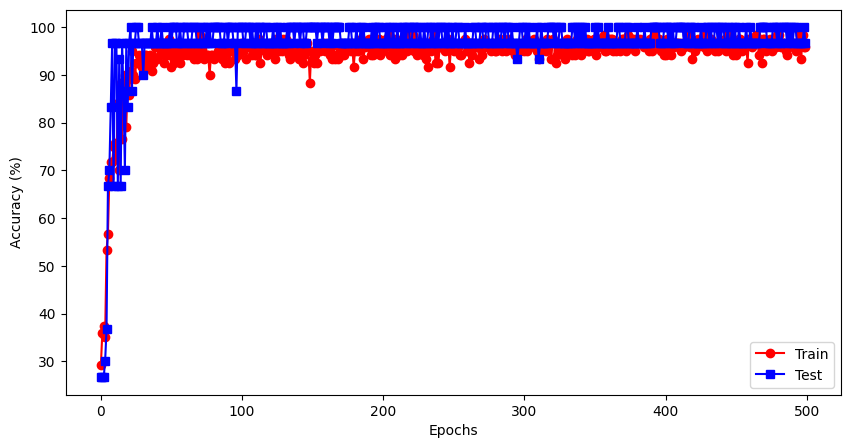

In [25]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'ro-')
plt.plot(testAcc,'bs-')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

# optional zoom-in to final epochs
# plt.xlim([300,500])
# plt.ylim([90,100.5])

plt.show()